# Outline
⭐ Overview of Stable Diffusion Pipeline

⭐ Image Generation process with Stable Diffusion

⭐ Exploring image generation settings

⭐ Finetuning Stable Diffusion with DreamBooth

This notebook is based on the following sources:
- [01_stable_diffusion_introduction.ipynb](https://github.com/huggingface/diffusion-models-class/blob/main/unit3/01_stable_diffusion_introduction.ipynb)
- [DreamBooth Stable Diffusion](https://colab.research.google.com/github/ShivamShrirao/diffusers/blob/main/examples/dreambooth/DreamBooth_Stable_Diffusion.ipynb)
- [DreamBooth fine-tuning with LoRA from PEFT](https://huggingface.co/docs/peft/main/en/task_guides/dreambooth_lora#inference-with-a-single-adapter)

## Step 1: Setup

Install diffusers and necessary dependencies

In [1]:
%%capture
!pip install -U diffusers datasets transformers accelerate

In [2]:
import os
import torch
import torchvision.transforms as T
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

In [3]:
# We'll use a couple of demo images later in the notebook
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

In [4]:
# Set device
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

## Step 2. Overview of components.

Diffusers provide a high-level user-friendly interface for image generation - so called **pipelines**. At the core of the toolbox are models (UNet denoisers, Autoencoders) and schedulers. Pipelines bundle these components together for convenience.

Alternatively, one create and use the models and schedulers separately.

Below we provide an on overview of the components and image generation process.

For illustration we will use `StableDiffusion v1.4`. Feel free to experiment with other models!

**Stable Diffusion**  

Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/).

It's trained on 512x512 images from a subset of the [LAION-2B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder, the model is relatively lightweight and can run on many consumer GPUs.

See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.

In [5]:
from diffusers import (
    StableDiffusionPipeline, # Stable Diffusion Text-2-Image pipeline
    UNet2DConditionModel, # Denoiser UNet
    AutoencoderKL, # VAE for latent space embedding
    PNDMScheduler # Diffusion scheduler
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

**Create a pipeline**

For the sake of efficiency we load the model in half precision - `fp16`.

Usually, this option doesn't affect image generation quality whereas making the generation process faster and saving memory.

In [6]:
pipeline = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    variant="fp16",
    torch_dtype=torch.float16, # precision
    device_map="balanced" # load model directly on GPU
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Let us have a look at the components of StableDiffusionPipeline.



In [7]:
print(list(pipeline.components.keys())) # List components

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']


The StableDiffusion pipeline has the following core components:
* UNet denoiser model
* VAE (only decoder part is needed on inference)
* Text encoder
* Text tokenizer
* Scheduler

In addition it comes with
* Feature Extractor - image processing transforms
* Safety Checker preventing generation of NSFW content (can be turned off 🍓 if you are 18+)

Let us cover core components in more detail below

### VAE

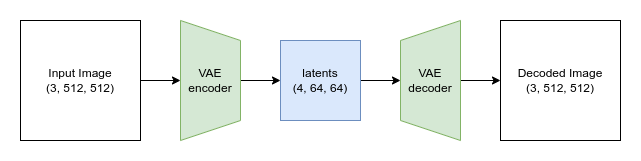

As you might remember from the lecture Stable Diffusion is *latent* diffusion model: the denoising process happens in the latent space with smaller spatial dimensions and the resulting latent is decoded pack to pixel space.


The VAE (variational autoencoder) is a type of model that can encode its input into a compressed representation and then decode this 'latent' representation back into something close to the original input. When generating images with Stable Diffusion, we first generate the latents by applying the diffusion process in the 'latent space' of the VAE, and then decode them at the end to view the resulting image.

Here is some code that takes an input image, encodes it to a latent representation and then decodes it again using the VAE:


In [ ]:
image_url = "https://opis-cdn.tinkoffjournal.ru/i/RkX0cDStClP2OV7fP0WVcOc4f_YZScHdfrrEF9iAsE0/h:600/w:600/Z3M6Ly9tZWRpYS1z/dG9yYWdlLXByb2R1/Y3Rpb24tdGovc29j/aWFsL3Byb2ZpbGUv/YWMxMzRhMjgua29u/X2Y4NmM5NTgxYzgw/ZDEzYzkwMWUxNzZl/ZDMyMWJlMmU3LnBu/Zw"
image = download_image(image_url)

Visualize image

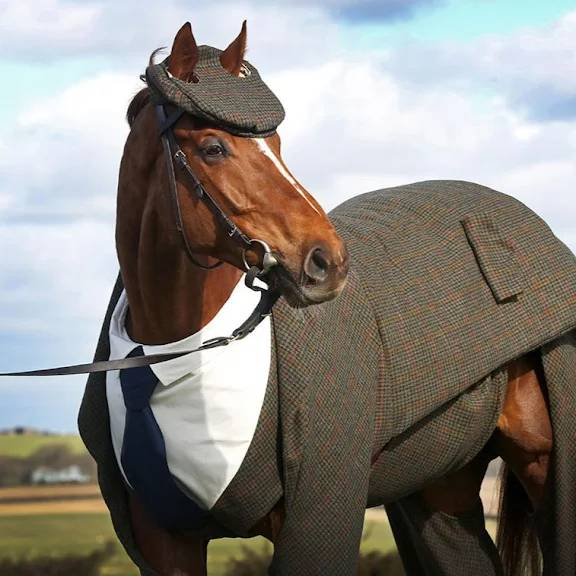

In [ ]:
image

Resize image to 512x512 and convert to tensor.

In [ ]:
transforms = T.Compose([
    T.Resize(512, interpolation=T.InterpolationMode.LANCZOS),
    T.ToTensor(),
    T.Lambda(lambda x: 2 * x - 1) # map [0, 1] to [-1, 1]
])
# Transform image
images = transforms(image).to(torch.float16)
# Add batch axis
images = images.unsqueeze(0)

NameError: name 'T' is not defined

In [ ]:
SD_SCALE_FACTOR = 0.18215
print(f"Original images shape: {images.shape}")
# Encode to latent space
with torch.no_grad():
  latents = SD_SCALE_FACTOR * pipeline.vae.encode(images).latent_dist.mean
print(f"Encoded latents shape: {latents.shape}")
# Decode again
with torch.no_grad():
  decoded_images = pipeline.vae.decode(latents / SD_SCALE_FACTOR).sample
print(f"Decoded images shape: {decoded_images.shape}")

Original images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


Let us visualize the decoded image

In [ ]:
transforms = T.Compose([
    T.Lambda(lambda x: 0.5 * (x.clamp(-1, 1) + 1)),
    T.ToPILImage(),
])
decoded_image = transforms(decoded_images[0])

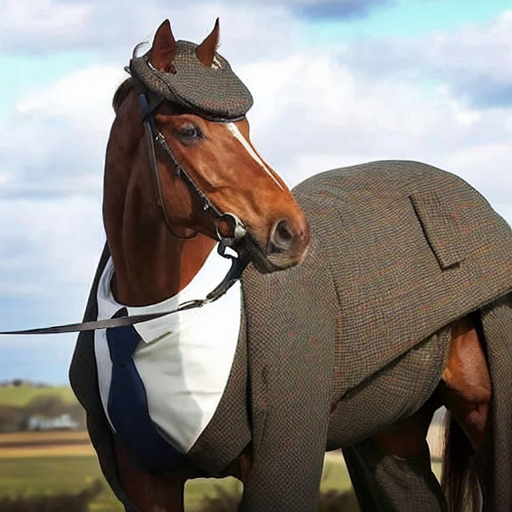

In [ ]:
decoded_image

Let us visualize latents

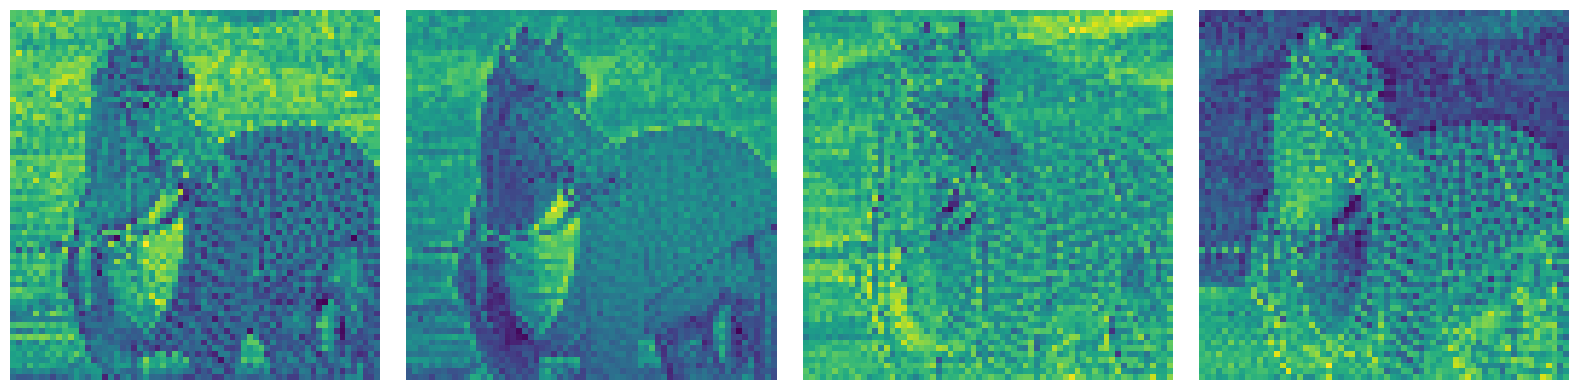

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 4))
for i in range(4):
  ax[i].imshow(latents[0, i].cpu().numpy());
  ax[i].axis("off");
fig.tight_layout()

Note that latents resemble original image.

### Text encoder and tokenizer

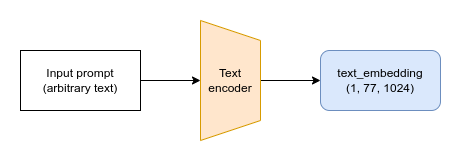

Text encoder turns an input string (the prompt) into a numerical representation that can be fed to the **UNet** as conditioning. The text is first turned into a series of tokens using the pipeline's tokenizer. The text encoder has a vocabulary of about *50k* tokens - any word isn't in this vocabulary is split into smaller sub-words. The tokens are then fed through the text encoder model itself - a transformer model that was originally trained as the text encoder for **CLIP**. The hope is that this pretrained transformer model has learnt rich representations of text that will be useful for the diffusion task too.

Let's test out this process by encoding an example prompt, first manually tokenizing and feeding it through the text encoder and then using the pipelines `encode_prompt` method to show the full process including padding/truncating the length to the maximum length of **77** tokens:


In [ ]:
# Tokenizing and encoding an example prompt manually

# Tokenize
input_ids = pipeline.tokenizer(["A horse in the coat"])['input_ids']
print("Input ID -> decoded token")
# Print output tokens ids and corresponding tokens
for input_id in input_ids[0]:
  print(f"{input_id} -> {pipeline.tokenizer.decode(input_id)}")

# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
  text_embeddings = pipeline.text_encoder(input_ids)['last_hidden_state']
print(f"Text embeddings shape: {text_embeddings.shape}")

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
4558 -> horse
530 -> in
518 -> the
7356 -> coat
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 7, 768])


These text embeddings (the so-called `hidden states` of the last transformer block in the text encoder model) will be fed to the **UNet** as an additional argument to the `forward` method, which we'll see below.

### The Scheduler

The scheduler stores the **noise schedule** and manages updating the noisy sample based on the model predictions.

The default scheduler is a `PNDMScheduler`, but you can use others (such as `LMSDiscreteScheduler`) as long as they are initialized with the same configuration.

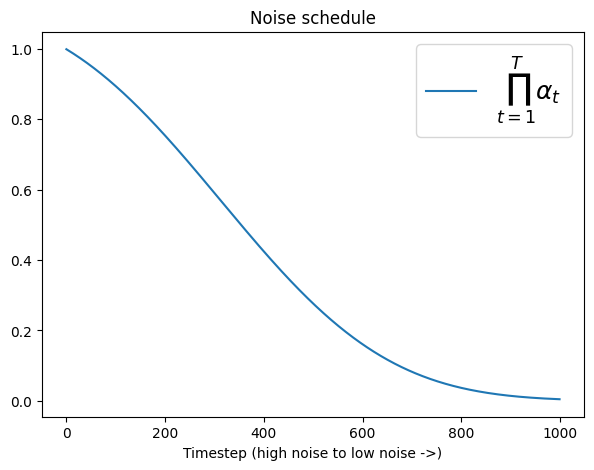

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(pipeline.scheduler.alphas_cumprod, label=r'$\prod_{t=1}^{T} \alpha_t$');
ax.set_xlabel('Timestep (high noise to low noise ->)');
ax.set_title('Noise schedule');
ax.legend(fontsize=18);

### The UNet

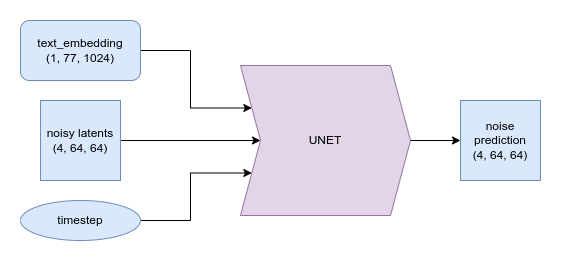

The Stable Diffusion **UNet** takes a noisy input $x_t$ and predicts the noise, just like the pixel-space **UNets** we've seen before

Unlike those previous examples, the input is not an image but is instead a latent representation of an image. And in addition to the **timestep conditioning**, this UNet also takes in the **text embeddings** of the prompt as an additional input.

Let us show a single forward step below.

In [ ]:
# Initialize timesteps
pipeline.scheduler.set_timesteps(num_inference_steps=50)
# Dummy inputs
timestep = pipeline.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64, device=device, dtype=torch.float16)
text_embeddings = torch.randn(1, 77, 768, device=device, dtype=torch.float16)
# Model prediction
with torch.no_grad():
  unet_output = pipeline.unet(latents, timestep, text_embeddings).sample
print(f"UNet output shape: {unet_output.shape}") # Same shape as the input latents

UNet output shape: torch.Size([1, 4, 64, 64])


Let us visualize the architecture

In [ ]:
pipeline.unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

Too bulky output!

Let us have a look at individual block.

In [ ]:
pipeline.unet.mid_block.resnets[0]

ResnetBlock2D(
  (norm1): GroupNorm(32, 1280, eps=1e-05, affine=True)
  (conv1): Conv2d(1280, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb_proj): Linear(in_features=1280, out_features=1280, bias=True)
  (norm2): GroupNorm(32, 1280, eps=1e-05, affine=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (conv2): Conv2d(1280, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (nonlinearity): SiLU()
)

Resnet block involves convolutions, normalizations and `time_emb_proj` for scale shift modulation.

In [ ]:
pipeline.unet.mid_block.attentions[0]

Transformer2DModel(
  (norm): GroupNorm(32, 1280, eps=1e-06, affine=True)
  (proj_in): Conv2d(1280, 1280, kernel_size=(1, 1), stride=(1, 1))
  (transformer_blocks): ModuleList(
    (0): BasicTransformerBlock(
      (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (attn1): Attention(
        (to_q): Linear(in_features=1280, out_features=1280, bias=False)
        (to_k): Linear(in_features=1280, out_features=1280, bias=False)
        (to_v): Linear(in_features=1280, out_features=1280, bias=False)
        (to_out): ModuleList(
          (0): Linear(in_features=1280, out_features=1280, bias=True)
          (1): Dropout(p=0.0, inplace=False)
        )
      )
      (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (attn2): Attention(
        (to_q): Linear(in_features=1280, out_features=1280, bias=False)
        (to_k): Linear(in_features=768, out_features=1280, bias=False)
        (to_v): Linear(in_features=768, out_features=1280, bias=False)
      

Transformer block includes following components:
* `attn1` - `Self Attention`
* `attn2` - `Cross Attention`
* `ff` - `Feedforward MLP`

## Step 3. Overview of image generation process.


Image generation process for Text-2-Image Latent Diffusion Model is the same iterative denoising procedure you we seen before.

However, there are several **crucial differences**:
* Diffusion process takes place in the latent space.
* Text conditioning is passed as an input to the model.
* For better generation quality and image fidelity one uses classifier free guidance.

Therefore, the sampling procedure looks as follows:
1. Initialize random noise.
2. Run sampling loop with conditional and unconditional prediction: $$\varepsilon_t^{CFG} = (1 + \gamma) \varepsilon_t(z_t, c) - \gamma \varepsilon_t(z_t, \emptyset)$$
3. Decode the resulting latent into pixel space.

The whole pipeline is illustrated below:

![](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png)

In [ ]:
guidance_scale = 8
num_inference_steps = 30
prompt = "A horse in a coat in anime style"
# Set up a generator for reproducibility
seed = 42
generator = torch.Generator(device=device).manual_seed(seed)

# 1. Encode the prompt
text_embeddings = pipeline._encode_prompt(
    prompt,
    device,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True
)

# 2. Generate random noise
latents = torch.randn((1, 4, 64, 64), device=device, dtype=torch.float16, generator=generator)
latents *= pipeline.scheduler.init_noise_sigma

# 3. Prepare the scheduler
pipeline.scheduler.set_timesteps(num_inference_steps, device=device)

# 4. Loop through the sampling timesteps
for i, t in enumerate(pipeline.scheduler.timesteps):
  # 4.1 Expand the latents for classifier free guidance
  latent_model_input = torch.cat([latents] * 2)
  # 4.2 Apply any scaling required by the scheduler
  latent_model_input = pipeline.scheduler.scale_model_input(latent_model_input, t)
  # 4.3 Predict the noise residual with the UNet
  with torch.no_grad():
    noise_pred = pipeline.unet(
        latent_model_input,
        t,
        encoder_hidden_states=text_embeddings
    ).sample

  # 4.4 Perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
  # 4.5 Compute the previous noisy sample x_t -> x_t-1
  latents = pipeline.scheduler.step(noise_pred, t, latents).prev_sample

# 5. Decode the resulting latents into an image
with torch.no_grad():
  image = pipeline.decode_latents(latents.detach())


/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:283: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:569: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


Let us visualize the generated image

In [ ]:
# image is np array
type(image)

numpy.ndarray

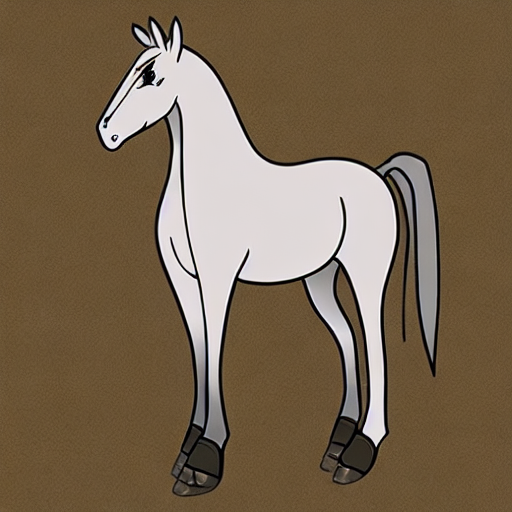

In [ ]:
# convert it into PIL image
pipeline.numpy_to_pil(image)[0]

Diffusers provide a simple-to-use pipelines where are steps shown above are implemented under the hood.

In [ ]:
image = pipeline([prompt], generator=generator, num_inference_steps=30, guidance_scale=8.0).images[0]

  0%|          | 0/30 [00:00<?, ?it/s]

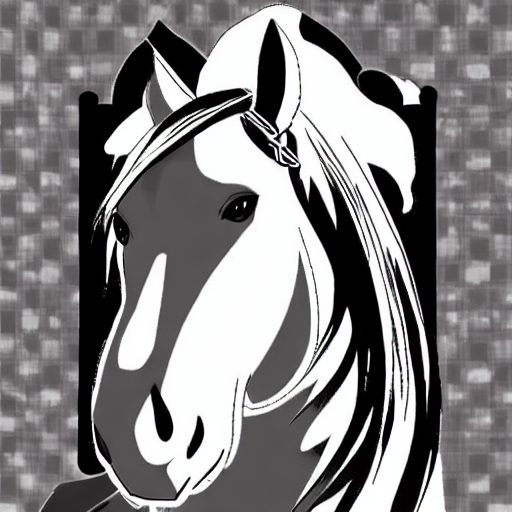

In [ ]:
image

## Step 4. Exploring image generation settings.

`num_inference_steps` and `guidance_scale` have a dramatic effect on the quality of resulting generations.

In general, image generation quality improves with more **sampling steps**. However, increase of steps leads to longer generation steps. Usually number of steps is determined based on trade-off between image quality and runtime. 20-50 steps (depending on solver) are typical choice.

As discussed in the lecture, higher value of CFG scale improves text-image alignment and image fidelity. However, this comes at the price of the decrease and diversity and the images tend to be oversaturrated for too large value of `guidance_scale`.

Let us explore these 2 parameters below:

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
# disable safety checker
pipeline.safety_checker = None

In [ ]:
guidance_scale_options = [1, 2, 4, 8, 16, 32]
num_inference_steps_options = [1, 4, 16, 32]

prompt = "a photograph of an astronaut riding a horse"

generator = torch.Generator(device="cuda")

images = []
for num_inference_steps in num_inference_steps_options:
  for guidance_scale in guidance_scale_options:
    # fix seed
    generator.manual_seed(42)
    image = pipeline(
        [prompt],
        generator=generator,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale
    ).images[0]
    images.append(image)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

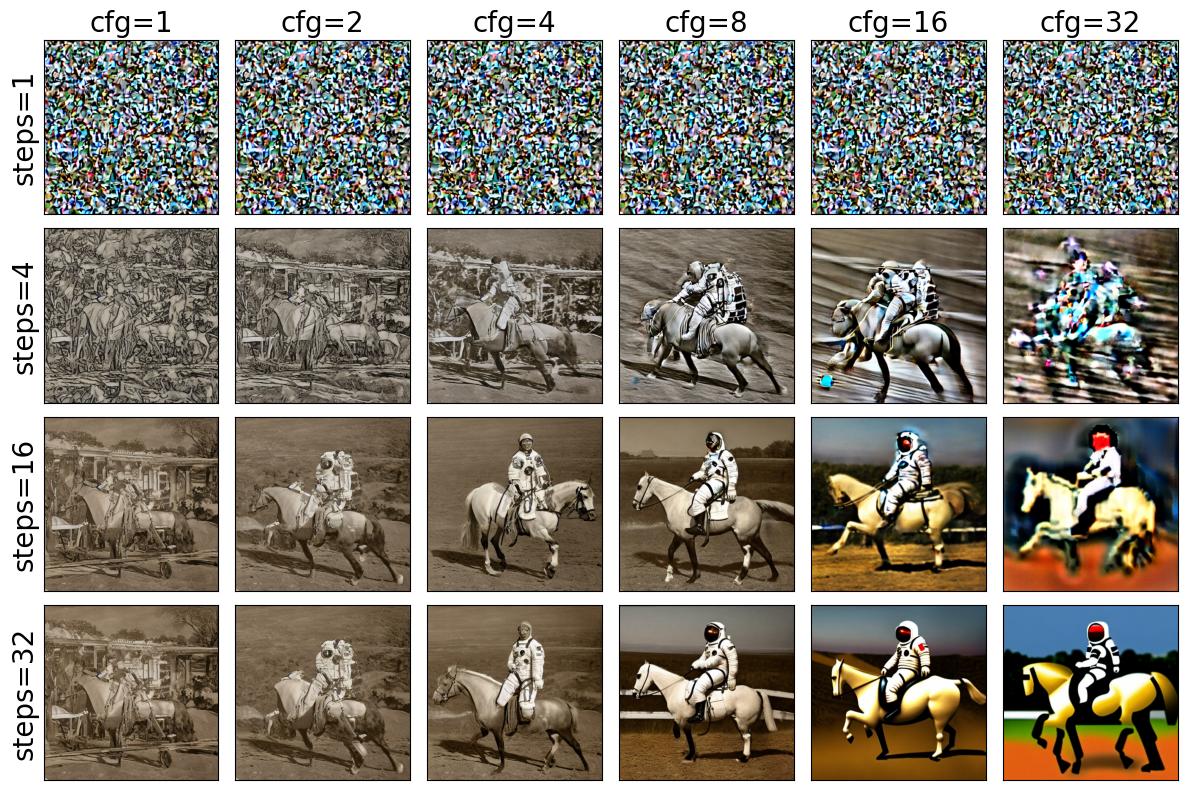

In [ ]:
nrows = len(num_inference_steps_options)
ncols = len(guidance_scale_options)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 2, nrows * 2))

for i in range(nrows):
  for j in range(ncols):
    ax[i, j].imshow(images[i * ncols + j])
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    if i == 0:
      ax[0, j].set_title(f"cfg={guidance_scale_options[j]}", fontsize=20)
    if j == 0:
      ax[i, 0].set_ylabel(f"steps={num_inference_steps_options[i]}", fontsize=20)

fig.tight_layout()

**Observations**

* For small number of inference steps Stable Diffusion yields random noise for any `guidance_scale`.
* For low `guidance_scale` images are very defective and do not resemble anything meaningful.
* For high `guidance_scale` images are oversaturated.

Impact on diversity

In [ ]:
num_inference_steps = 32
seeds = [3, 42, 66, 77, 777]

prompt = "a photograph of an astronaut riding a horse"

generator = torch.Generator(device="cuda")

low_cfg_images = []
for seed in seeds:
    # fix seed
    generator.manual_seed(seed)
    image = pipeline(
        [prompt],
        generator=generator,
        num_inference_steps=num_inference_steps,
        guidance_scale=4
    ).images[0]
    low_cfg_images.append(image)

high_cfg_images = []
for seed in seeds:
    # fix seed
    generator.manual_seed(seed)
    image = pipeline(
        [prompt],
        generator=generator,
        num_inference_steps=num_inference_steps,
        guidance_scale=16
    ).images[0]
    high_cfg_images.append(image)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

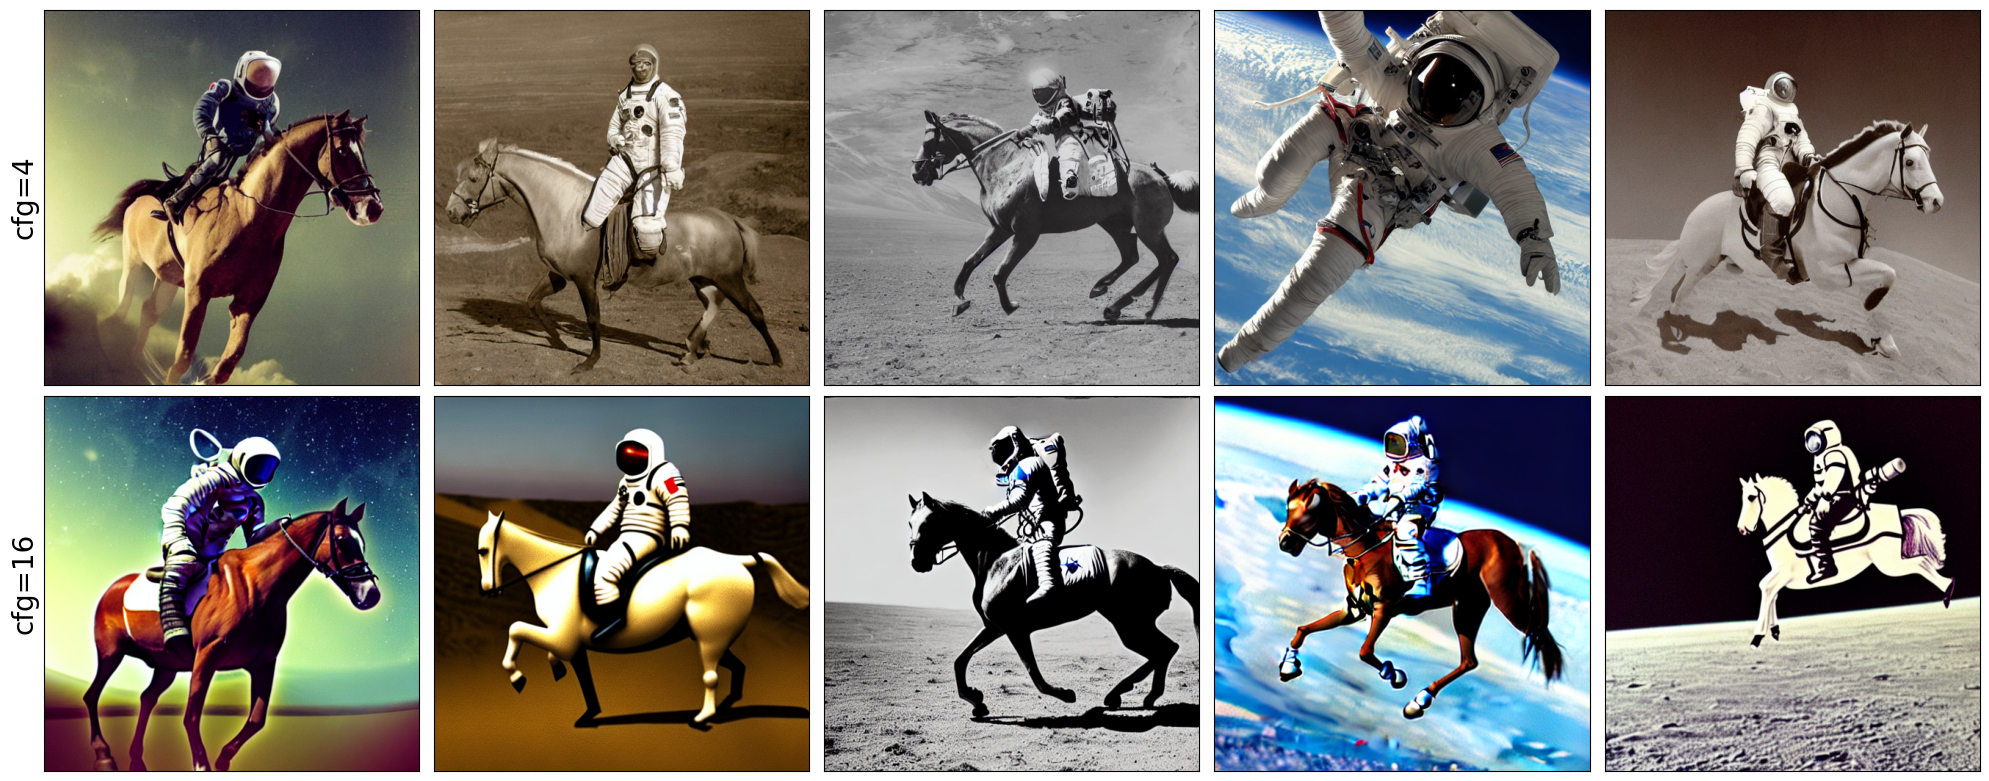

In [ ]:
ncols = len(seeds)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(ncols * 4, 2 * 4))

for j in range(ncols):
    ax[0, j].imshow(low_cfg_images[j])
    ax[0, j].set_xticks([])
    ax[0, j].set_yticks([])
    ax[1, j].imshow(high_cfg_images[j])
    ax[1, j].set_xticks([])
    ax[1, j].set_yticks([])
    if j == 0:
      ax[0, j].set_ylabel("cfg=4", fontsize=20)
      ax[1, j].set_ylabel("cfg=16", fontsize=20)

fig.tight_layout()

Samples with smaller `guidance_scale` are more diverse but do not always follow the prompt.

## Step 5. Finetuning Diffusion model.

Imagine, you would like to generate an image with you, your friend, your pet, your favourite toy, whatever.

Whereas `Stable Diffusion` is pretty good at generating general concepts and celebrities it is unlikely to have seen some specific and narrow concepts in the training data. Therefore, we need to teach the model somehow about it.

### What is DreamBooth?

![](https://dreambooth.github.io/DreamBooth_files/teaser_static.jpg)

DreamBooth is a technique to teach new concepts to pretrained diffusion model using a specialized form of fine-tuning.

The way DreamBooth works is as follows:

* Collect input images (more is better) of a subject (e.g., your dog) and define a unique identifier [V] that refers to the subject. This identifier is a some made up word like `flffydog` which is implanted in different text prompts at inference time to place the subject in different contexts.
* Fine-tune the diffusion model by providing the images together with a text prompt like "A photo of a [V] dog" that contains the unique identifier and class name (i.e., "dog" in this example).
* (Optionally) Apply a special _class-specific prior preservation loss_, which leverages the semantic prior that the model has on the class and encourages it to generate diverse instances belong to the subject's class by injecting the class name in the text prompt. In practice, this step is only really needed for human faces and can be skipped for the themes we'll be exploring in this hackathon.

An overview of the DreamBooth technique is shown in the image below:

![](https://dreambooth.github.io/DreamBooth_files/high_level.png)

When tuning Diffusion model we would like to meet following two requirements:
* Learn new concept.
* Preserve prior knowledge.

Therefore, a natural way to-go is to finetune a **small** fraction of parameters.

Low-Rank Adapters ([LoRA](https://arxiv.org/abs/2106.09685)) are a common choice.

The idea is quite simple:
1. Choose a subset of linear/convolutional layers to be modified
2. Train Low-Rank addition to the weights of chosen layers:
$$
\mathbf{W} = \mathbf{W} + \frac{\alpha}{r} A B
$$

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRtA1GBq4aUlgQA61LdWNi5zmwSK-HL44lSYg&s)

If rank $r$ of the adapter is much smaller than the dimensions of the matrices $d$, number of trainable parameters is much smaller than the total amount of weights of the model, leading to significant reduction in memory consumption (on parameter gradients and optimizer states) for large models.


Below we will adopt `train_dreambooth.py` from [PEFT](https://huggingface.co/docs/peft/index) library.

### Setup

First we need to install 🤗 PEFT.

In [ ]:
!git clone https://github.com/huggingface/peft

Move to `examples`

In [ ]:
%cd peft/examples/lora_dreambooth

/content/peft/examples/lora_dreambooth


In [ ]:
!pip install -r requirements.txt
!pip install git+https://github.com/huggingface/peft

  Cloning https://github.com/huggingface/peft to /tmp/pip-req-build-hw8ut3nh
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft /tmp/pip-req-build-hw8ut3nh
  Resolved https://github.com/huggingface/peft to commit c29810bad23f24c637d8e0bce42866d6748d94e2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


**Prepare images**

Below we will download images of one pokemon popular in Belarus. You may experiment with any other concept you like.

In [ ]:
!mkdir -p images

In [ ]:
!curl https://www.orthrusonline.ru/static/images/p/nextgen/bulbasaur.png -o images/bulbasaur1.png
!curl https://static.wikia.nocookie.net/pokemon/images/5/57/0001Bulbasaur_AG_anime_2.png/revision/latest/scale-to-width-down/250?cb=20150101074702 -o images/bulbasaur2.png
!curl https://w7.pngwing.com/pngs/856/172/png-transparent-bulbasaur-pokemon-adventures-pikachu-charmander-bulbasaur-mammal-leaf-carnivoran.png -o images/bulbasaur3.png
!curl https://pm1.aminoapps.com/6685/15315dfa800a1b5433590e67a3bca901e93ab923_00.jpg -o images/bulbasaur4.jpg
!curl https://w7.pngwing.com/pngs/840/277/png-transparent-bulbasaur-thumbnail.png -o images/bulbasaur5.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25101  100 25101    0     0  27779      0 --:--:-- --:--:-- --:--:-- 27766
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 72023  100 72023    0     0   416k      0 --:--:-- --:--:-- --:--:--  418k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31466  100 31466    0     0   278k      0 --:--:-- --:--:-- --:--:--  279k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34397  100 34397    0     0   244k      0 --:--:-- --:--:-- --:--:--  245k
  % Total    % Received % Xferd  Average Speed   Tim

Let us visualize images

In [ ]:
!ls images

bulbasaur1.png	bulbasaur2.png	bulbasaur3.png	bulbasaur4.jpg	bulbasaur5.jpg


In [ ]:
images = []
for image_path in os.listdir("images"):
  images.append(Image.open(os.path.join("images", image_path)))

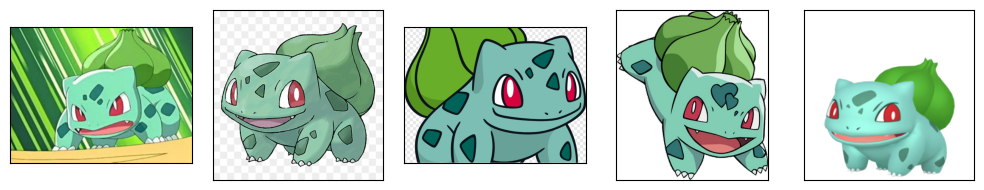

In [ ]:
ncols = len(images)
fig, ax = plt.subplots(ncols=ncols, figsize=(ncols * 2, 2))

for j in range(ncols):
    ax[j].imshow(images[j])
    ax[j].set_xticks([])
    ax[j].set_yticks([])

fig.tight_layout()

In [ ]:
# free memory previously occupied by SD before training.
del pipeline
torch.cuda.empty_cache()

In [ ]:
# we do not need these anyway
!rm -rf images/.ipynb_checkpoints

Code below takes a while (10-15 minutes on Colab).

Dreambooth finetuning is an essence a usual diffusion model training for relatively short number of iterations (100-1000).

In [ ]:
%%bash
MODEL_NAME="CompVis/stable-diffusion-v1-4"
INSTANCE_DIR=images
OUTPUT_DIR="stable-diffusion-v1-4-bulbasaur"

accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --train_text_encoder \
  --num_dataloader_workers=1 \
  --instance_prompt="a photo of bulbasaur" \
  --class_prompt="a photo of an animal" \
  --resolution=512 \
  --train_batch_size=1 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=200 \
  --use_lora \
  --lora_r 16 \
  --lora_alpha 27 \
  --lora_text_encoder_r 16 \
  --lora_text_encoder_alpha 17 \
  --learning_rate=1e-4 \
  --gradient_accumulation_steps=1 \
  --gradient_checkpointing \
  --max_train_steps=400

Let us run inference the Dreambooth finetuned model.

In [ ]:
from peft import PeftModel, LoraConfig

The function below loads LoRA adapters and merges them into model.

In [ ]:
def get_lora_sd_pipeline(
    ckpt_dir: str,
    base_model_name_or_path: str,
    dtype=torch.float16,
    device="cuda",
    adapter_name="default"
):
    unet_sub_dir = os.path.join(ckpt_dir, "unet")
    text_encoder_sub_dir = os.path.join(ckpt_dir, "text_encoder")
    if os.path.exists(text_encoder_sub_dir) and base_model_name_or_path is None:
        config = LoraConfig.from_pretrained(text_encoder_sub_dir)
        base_model_name_or_path = config.base_model_name_or_path

    pipe = StableDiffusionPipeline.from_pretrained(base_model_name_or_path, torch_dtype=dtype).to(device)
    pipe.unet = PeftModel.from_pretrained(pipe.unet, unet_sub_dir, adapter_name=adapter_name)

    if os.path.exists(text_encoder_sub_dir):
        pipe.text_encoder = PeftModel.from_pretrained(
            pipe.text_encoder, text_encoder_sub_dir, adapter_name=adapter_name
        )

    if dtype in (torch.float16, torch.bfloat16):
        pipe.unet.half()
        pipe.text_encoder.half()

    pipe.to(device)
    return pipe

In [ ]:
pipe = get_lora_sd_pipeline(
    base_model_name_or_path="CompVis/stable-diffusion-v1-4",
    ckpt_dir="stable-diffusion-v1-4-bulbasaur",
    adapter_name="bulbasaur"
)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Let us generate an image with custom prompt.

In [ ]:
prompt = "bulbasaur in cowboy hat, wild west"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

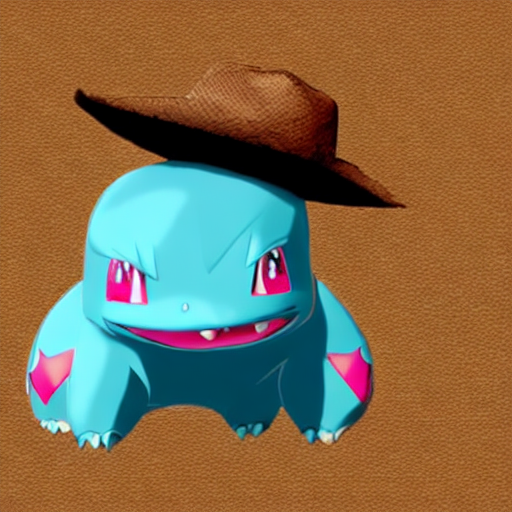

In [ ]:
image

Pretty nice, isn't it?